# Parent Child Relationships

+ *parent variables* influence other variables
+ *child variables* are influenced by other variables

Most of the initial part is self explanatory if you're familiar with random variables.

Stochastic variables are non deterministic.

Each stochastic variable will need to be initialized by using something like `pm.Uniform()` - use `??` to check what parameters are needed.

## Including observations in the Model

PyMC stochastic variables have a keyword `observed` which accepts a boolean(`False` by default). The keyword `observed` has a very simple role - fix the variables current value, i.e. make `value` immutable. We have to specify an initial `value` in the variable's creation, equal to the observations we wish to include.

### Modeling Approach

Main point here is to think of the data generation process.

# Bayesian A/B Testing

Let's start off with just A

In [123]:
import pymc as pm

In [159]:
#p = pm.Beta("p", alpha = 30, beta = 30)
p = pm.Uniform("p", lower = 0, upper = 1)

In [160]:
p_true = 0.05
N = 50

# generate data using p_true
occurrences = pm.rbernoulli(p_true, N)

In [161]:
# include observations which are bernoulli

obs  = pm.Bernoulli("obs", p , value = occurrences, observed = True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.0 sec

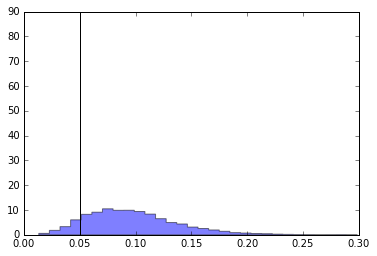

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mcmc.trace("p")[:], bins = 30, 
         histtype = "stepfilled", normed = True,
        alpha = 0.5)
plt.vlines(p_true, 0, 90)

## A & B together

In [211]:
import pymc as pm

true_p_A = 0.05
true_p_B = 0.045

n_A = 1500
n_B = 1500

# Some random observations
observations_A = pm.rbernoulli(true_p_A, n_A)
observations_B = pm.rbernoulli(true_p_B, n_B)

print(observations_A.mean())
print(observations_B.mean())

0.0493333333333
0.038


In [212]:
# Set up model

p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

@pm.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_A - p_B

obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A,
                    observed = True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B,
                    observed = True)

mcmc = pm.MCMC([p_A, p_B, obs_A, obs_B, delta])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec

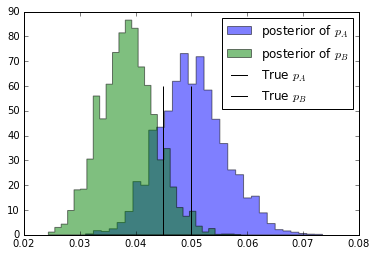

In [213]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

plt.hist(p_A_samples, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "posterior of $p_A$", normed = True);
plt.hist(p_B_samples, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "posterior of $p_B$", normed = True);
plt.vlines(true_p_A, 0 , 60, label = "True $p_A$");
plt.vlines(true_p_B, 0 , 60, label = "True $p_B$");
plt.legend();

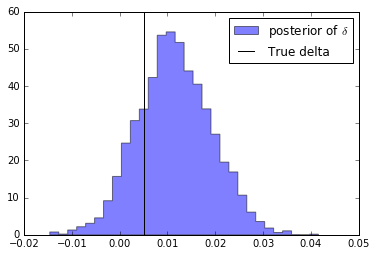

In [215]:
plt.hist(delta_samples, histtype="stepfilled", alpha = 0.5, 
        bins = 30, label = "posterior of $\delta$", 
         normed = True);
plt.vlines(true_p_A - true_p_B, 0 , 60, label = "True delta");
plt.legend();

In [216]:
(delta_samples > 0).mean()

0.93899999999999995

### PyMC Tricks

+ Lighter deterministic variables using `Lambda` class:

`beta = pm.Normal("coefficients", 0, size=(N, 1))
x = np.random.randn((N, 1))
linear_combination = pm.Lambda(lambda x=x, beta=beta: np.dot(x.T, beta))
`

+ Arrays of PyMC variables

`N = 10
x = np.empty(N, dtype=object)
for i in range(0, N):
    x[i] = pm.Exponential('x_%i' % i, (i + 1) ** 2)
    `

### Challenger Example

What is the probability of damage as a function of temperature?

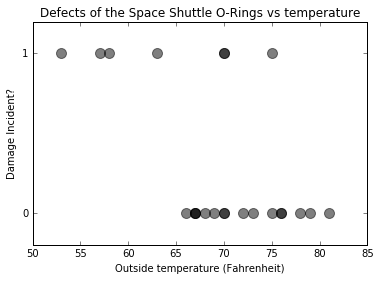

In [225]:
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=100, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")

We'll use a logistic function with a bias term.

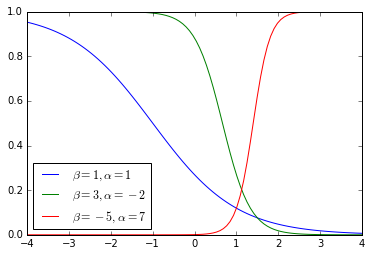

In [232]:
def logistic(x, beta, alpha = 0):
    return 1.0 / (1.0 + np.exp(beta * x + alpha))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1, 1), label = r"$\beta = 1, \alpha = 1$")
plt.plot(x, logistic(x, 3, -2), label = r"$\beta = 3, \alpha = -2$")
plt.plot(x, logistic(x, -5, 7), label = r"$\beta = -5, \alpha = 7$")
plt.legend(loc = "lower left");



Let's start modeling this in PyMC. The $β,α$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a Normal random variable, introduced next.


In [235]:
temperature = challenger_data[:,0]
D = challenger_data[:,1]

beta = pm.Normal("beta", 0, 0.001, value = 0)
alpha = pm.Normal("alpha", 0, 0.001, value = 0)

@pm.deterministic
def p(t = temperature, alpha = alpha, beta = beta):
    return 1.0 / (1. + np.exp(beta*t + alpha))

Why do we set `value = 0`?

We have probabilities, but we need to connect them to our observed data - defects. This is a Bernoulli random variable. Thus the model can look like $Defect D_i \sim Bern(p(t_i))$


Notice in the above code we had to set the values of beta and alpha to 0. The reason for this is that if beta and alpha are very large, they make p equal to 1 or 0. Unfortunately, pm.Bernoulli does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So by setting the coefficient values to 0, we set the variable p to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in PyMC. 

In [236]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [237]:
observed = pm.Bernoulli("bernoulli_obs", p, value = D, observed = True)
model = pm.Model([observed, beta, alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 11.2 sec

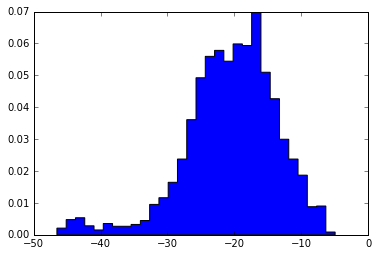

In [245]:
alpha_samples = mcmc.trace('alpha')[:,None]
beta_samples = mcmc.trace('beta')[:,None]

plt.hist(alpha_samples, histtype = "stepfilled", 
        bins = 30, normed = True);

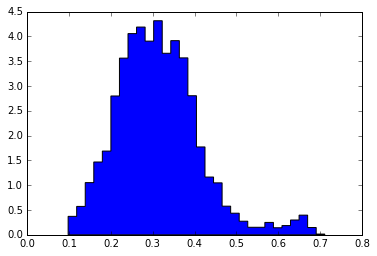

In [246]:
plt.hist(beta_samples, histtype = "stepfilled", 
        bins = 30, normed = True);

All samples of β
β
 are greater than 0. If instead the posterior was centered around 0, we may suspect that β=0
β=0
, implying that temperature has no effect on the probability of defect. 

Similarly, all α
α
 posterior values are negative and far away from 0, implying that it is correct to believe that α
α
 is significantly less than 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected). 

Next, let's look at the expected probability for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for p(ti)

In [255]:
t = np.linspace(temperature.min() - 5, 
               temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis = 0)

(10000, 50)

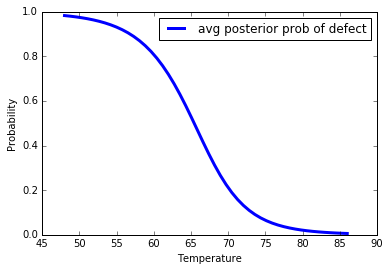

In [259]:
plt.plot(t, mean_prob_t, lw=3, label = "avg posterior prob of defect")
plt.legend();
plt.xlabel("Temperature");
plt.ylabel("Probability");

Let's plot the 95% interval

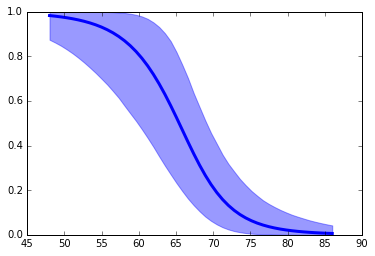

In [262]:
from scipy.stats.mstats import mquantiles

qs = mquantiles(p_t, [0.025, 0.975], axis = 0)
plt.plot(t, mean_prob_t, lw=3, label = "avg posterior prob of defect")
plt.fill_between(t[:,0], *qs, alpha = 0.4, color ='b');

As temp approached 60, we are fairly confident that failure might have occurred.

Let's look at the day of the challenger disaster with temp at 31.

(0.995, 1)

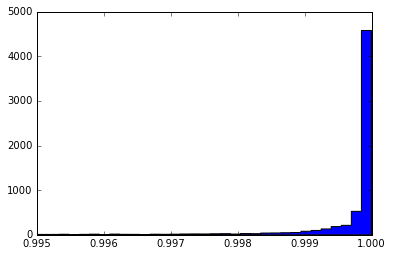

In [269]:
prob_31 = logistic(31, beta_samples, alpha_samples)

plt.hist(prob_31, bins = 1000, normed= True, 
        histtype = "stepfilled");
plt.xlim(0.995, 1)

### Goodness of Fit


We can think: how can we test whether our model is a bad fit? An idea is to compare observed data (which if we recall is a fixed stochastic variable) with an artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

In [271]:
simulated_data = pm.Bernoulli("simulation_data", p)
N = 10000

mcmc = pm.MCMC([simulated_data, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.1 sec

In [272]:
simulations = mcmc.trace("simulation_data")[:]
print(simulations.shape)

(10000, 23)


In [273]:
posterior_probability = simulations.mean(axis=0)

In [276]:
ix = np.argsort(posterior_probability)
print("Prob | Defect")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

Prob | Defect
0.02  |   0
0.03  |   0
0.03  |   0
0.06  |   0
0.06  |   0
0.07  |   0
0.07  |   1
0.11  |   0
0.12  |   0
0.18  |   0
0.18  |   1
0.18  |   1
0.18  |   0
0.22  |   0
0.26  |   0
0.29  |   0
0.30  |   0
0.30  |   0
0.35  |   0
0.51  |   1
0.75  |   1
0.79  |   1
0.89  |   1


In [277]:
from separation_plot import separation_plot


separation_plot(posterior_probability, D)

ImportError: No module named 'separation_plot'

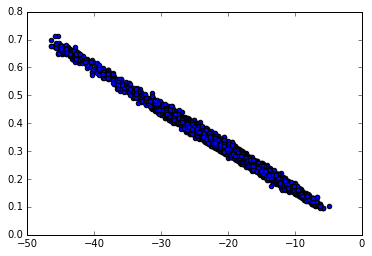

In [279]:
plt.scatter(alpha_samples, beta_samples)